In [64]:
# Time Series Prediction with LSTM
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from pickle import dump

In [65]:
#convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
  a = dataset[i:(i+look_back), 0]
  dataX.append(a)
  dataY.append(dataset[i + look_back, 0])
 return numpy.array(dataX), numpy.array(dataY)

In [66]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [67]:
# load the dataset
dataset_name = "q1-20210810"
product_name = "no2"
file_path = 'dataset/'+dataset_name+'.csv'
dataframe = pd.read_csv(file_path)
print("Dataframe: \n", dataframe)
dataset = numpy.asarray(dataframe[product_name]).reshape(-1,1)
print("Dataset: \n", dataset)


Dataframe: 
             date dist        co       no2        o3  so2  ch4      hcho
0     2018-04-30   q1  0.036519  0.000059  0.127509  0.0    0  0.000000
1     2018-05-01   q1  0.035765  0.000053  0.128756  0.0    0  0.000000
2     2018-05-02   q1  0.037218  0.000051  0.127053  0.0    0  0.000000
3     2018-05-03   q1  0.000000  0.000000  0.120879  0.0    0  0.000000
4     2018-05-04   q1  0.000000  0.000000  0.121712  0.0    0  0.000000
...          ...  ...       ...       ...       ...  ...  ...       ...
1194  2021-08-06   q1  0.000000  0.000000  0.120559  0.0    0  0.000000
1195  2021-08-07   q1  0.020865  0.000000  0.119257  0.0    0  0.000000
1196  2021-08-08   q1  0.025278  0.000000  0.118261  0.0    0  0.000000
1197  2021-08-09   q1  0.000000  0.000000  0.120582  0.0    0  0.000295
1198  2021-08-10   q1  0.026092  0.000000  0.120392  0.0    0  0.000000

[1199 rows x 8 columns]
Dataset: 
 [[5.89875090e-05]
 [5.31632941e-05]
 [5.09173915e-05]
 ...
 [0.00000000e+00]
 [0.000000

In [68]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
print("Dataset after scale: \n", dataset)

Dataset after scale: 
 [[0.30101245]
 [0.27129156]
 [0.25983075]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]


In [69]:
# split into train and test sets
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [70]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print("TrainX shape: ", trainX.shape)
print("TrainY shape: ", trainY.shape)

TrainX shape:  (1077, 1)
TrainY shape:  (1077,)


In [71]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [72]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
history = model.fit(trainX, trainY, epochs=1000, batch_size=10, verbose=2,
          validation_data=(testX, testY))

score = model.evaluate(testX, testY, verbose=0)
print('score: test score = ', score)

# save the model
model.save('models/rnn-lstm-'+product_name)
# save the scaler
dump(scaler, open('models/rnn-lstm-'+product_name+'/scaler.pkl', 'wb'))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
108/108 - 3s - loss: 0.0399 - val_loss: 0.0155
Epoch 2/1000
108/108 - 0s - loss: 0.0374 - val_loss: 0.0163
Epoch 3/1000
108/108 - 0s - loss: 0.0373 - val_loss: 0.0164
Epoch 4/1000
108/108 - 0s - loss: 0.0373 - val_loss: 0.0165
Epoch 5/1000
108/108 - 0s - loss: 0.0373 - val_loss: 0.0164
Epoch 6/1000
108/108 - 1s - loss: 0.0373 - val_loss: 0.0160
Epoch 7/1000
108/108 - 0s - loss: 0.0372 - val_loss: 0.0166
Epoch 8/1000
108/108 - 0s - loss: 0.0372 - val_loss: 0.0166
Epoch 9/1000
108/108 - 1s - loss:

INFO:tensorflow:Assets written to: models/rnn-lstm-no2/assets


INFO:tensorflow:Assets written to: models/rnn-lstm-no2/assets


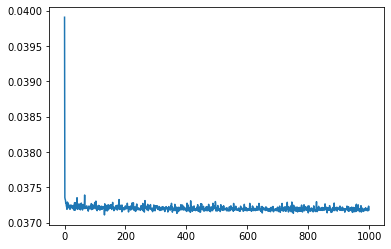

In [73]:
plt.plot(history.history['loss'])

In [74]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

_input2d = numpy.array([[0.003],[0.0003]])
_input_scaled2d = scaler.transform(_input2d)
_input_scaled3d = _input_scaled2d[:, :, numpy.newaxis]
print(_input_scaled3d)


[[[15.30895878]]

 [[ 1.53089588]]]


In [75]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

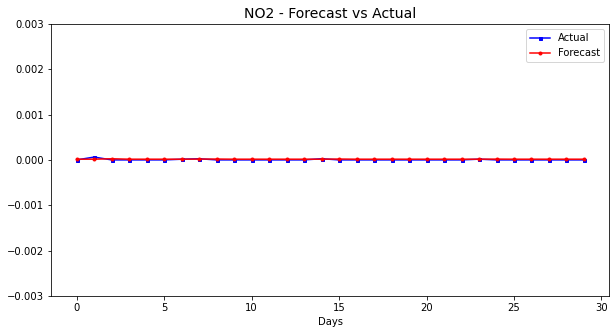

In [76]:
test_Y = testY[0][len(testY[0])-31:len(testY[0])-1]
test_Ypred = testPredict[len(testPredict)-31:len(testPredict)-1]
plt.subplots(figsize=(10, 5))
plt.title(product_name.upper() + " - Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(numpy.ravel(test_Y)), "bs-", markersize=3, label="Actual")
plt.plot(pd.Series(numpy.ravel(test_Ypred)), "ro-", markersize=3, label="Forecast")
plt.legend(loc="best")
plt.xlabel("Days")
plt.ylim([-0.003,0.003])
plt.show()

In [77]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.8f RMSE' % (trainScore),"max in Train =", trainY.max(),", min =", trainY.min(),", mean =", trainY.mean())
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.8f RMSE' % (testScore),"max in Test =", testY.max(),", min =", testY.min(),", mean =", testY.mean())

Train Score: 0.00003776 RMSE max in Train = 0.00019596368656493723 , min = 0.0 , mean = 1.9956440678238014e-05
Test Score: 0.00002486 RMSE max in Test = 0.0001271183864446357 , min = 0.0 , mean = 8.054272904577743e-06


In [78]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [79]:
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

In [80]:
# # plot baseline and predictions
# #plt.plot(scaler.inverse_transform(testY),"b-", label="Train")
# plt.plot(trainPredictPlot,"y-", label="Train pred")
# #plt.plot(scaler.inverse_transform(testY)[0],"b-", label="Test")
# plt.plot(testPredictPlot, "g-", label="Test pred")
# plt.legend(loc="best")
# #plt.ylim([-400,400])
# plt.show()
